In [1]:
import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("/Users/withmocha/Desktop/DATA/BOAZ/미니 프로젝트 1/data/test data/news.csv")
data
data.drop(data.columns[0], axis=1, inplace=True)
print(len(data.iloc[0,0]))
data['title'] = data['title'] + data['text']
print(len(data.iloc[0,0]))
data

28
7546


,title,text,label
0,"You Can Smell Hillary’s FearDaniel Greenfield,...","Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathyU.S...,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matte...,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [3]:
for i in range(data.shape[0]):
    if data.iloc[i,2]=='FAKE':
        data.iloc[i,2]=1
    else:
        data.iloc[i,2]=0

In [4]:
X = pd.DataFrame(data=data['title'])
Y = pd.DataFrame(data=data['label'])

In [5]:
X

,title
0,"You Can Smell Hillary’s FearDaniel Greenfield,..."
1,Watch The Exact Moment Paul Ryan Committed Pol...
2,Kerry to go to Paris in gesture of sympathyU.S...
3,Bernie supporters on Twitter erupt in anger ag...
4,The Battle of New York: Why This Primary Matte...
...,...
6330,State Department says it can't find emails fro...
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332,Anti-Trump Protesters Are Tools of the Oligarc...
6333,"In Ethiopia, Obama seeks progress on peace, se..."


In [6]:
Y

,label
0,1
1,1
2,0
3,1
4,0
...,...
6330,0
6331,1
6332,1
6333,0


In [7]:
texts = X['title'].tolist()
labels = Y['label'].tolist()
texts = [str(text) if pd.notna(text) else "" for text in texts]

In [8]:
val_texts=texts
val_labels=labels

In [9]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [10]:
def encode_data(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

In [11]:
val_input_ids, val_attention_masks = encode_data(val_texts, tokenizer)

In [12]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [13]:
def create_transformer_input(input_ids, attention_masks, batch_size=32):
    def gen():
        for i in range(0, len(input_ids), batch_size):
            yield input_ids[i:i + batch_size], attention_masks[i:i + batch_size]

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(tf.TensorSpec(shape=(None, input_ids.shape[1]), dtype=tf.int32),
                          tf.TensorSpec(shape=(None, attention_masks.shape[1]), dtype=tf.int32))
    )

    features = []
    for batch_input_ids, batch_attention_masks in dataset:
        outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_masks)
        features.append(outputs.last_hidden_state)

    return tf.concat(features, axis=0)

In [14]:
val_features = create_transformer_input(val_input_ids, val_attention_masks)

2024-08-25 21:41:30.648599: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
import numpy as np

val_labels = np.array(val_labels)

In [16]:
import tensorflow as tf 
from keras.models import load_model

LSTM_model_path='/Users/withmocha/Desktop/DATA/BOAZ/미니 프로젝트 1/model/bi lstm/BiLSTM model.keras'
LSTM_model = tf.keras.models.load_model(LSTM_model_path)
LSTM_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 768)]        0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                205056    
 onal)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 205121 (801.25 KB)
Trainable params: 205121 (801.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
val_features

<tf.Tensor: shape=(6335, 128, 768), dtype=float32, numpy=
array([[[-3.39894481e-02,  4.34486568e-02, -3.67913395e-04, ...,
         -9.57523137e-02, -2.91928742e-02, -4.59877476e-02],
        [ 9.79445428e-02, -1.11725554e-01,  1.32705137e-01, ...,
          4.14046139e-01, -1.85978916e-02, -1.53752804e-01],
        [ 2.67634671e-02,  8.76445770e-02, -2.23051757e-03, ...,
          8.38902593e-02,  2.60981284e-02,  2.21404340e-02],
        ...,
        [-1.15029991e-01, -1.95390195e-01,  2.36002907e-01, ...,
         -6.54841661e-01,  1.25894934e-01,  7.40672201e-02],
        [-5.54237515e-02,  1.73273474e-01,  3.63890886e-01, ...,
         -2.58570969e-01,  1.10757530e-01,  1.85237639e-02],
        [-1.72375031e-02, -2.20326893e-02,  6.20599128e-02, ...,
          6.84908181e-02,  7.90255144e-02,  3.16771306e-02]],

       [[-6.71724677e-02,  2.74872072e-02, -6.77573029e-03, ...,
         -8.83671716e-02, -5.00722043e-02,  1.09875193e-02],
        [ 1.09439731e-01, -2.79452741e-01,  5

198/198 [==============================] - 9s 38ms/step


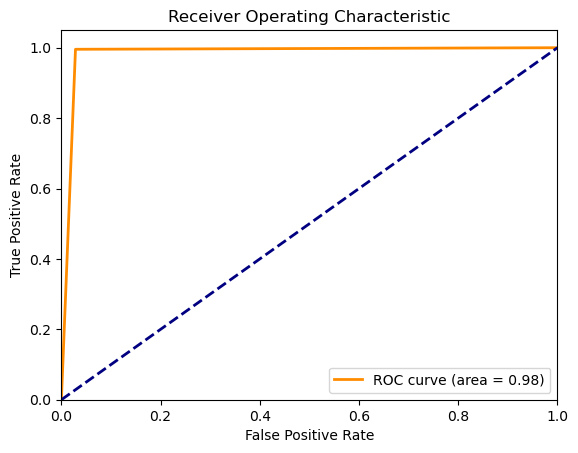

In [18]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score

val_pred = LSTM_model.predict(val_features)
val_pred = (val_pred > 0.5).astype(int)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score

fpr, tpr, _ = roc_curve(val_labels, val_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

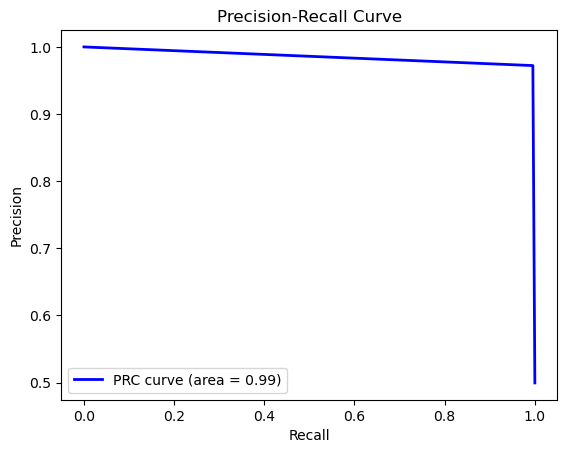

In [19]:
precision, recall, _ = precision_recall_curve(val_labels, val_pred)
prc_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

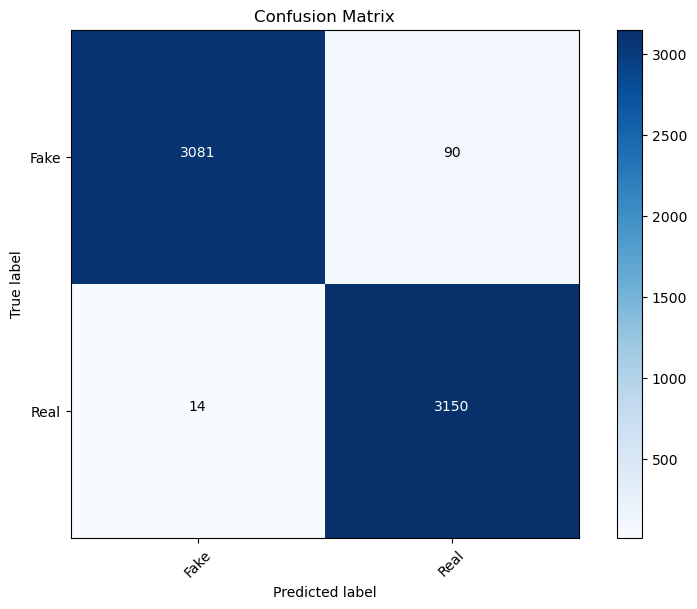

In [20]:
import itertools

conf_matrix = confusion_matrix(val_labels, val_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
accuracy = accuracy_score(val_labels, val_pred)
print('Accuracy Score:', accuracy)

Accuracy Score: 0.9835832675611681
